In [30]:
# Decoding + Reconstruction + Ground Truth Extraction

import glob
import os
from reconstruct import reconstruct_object
from decode import decode_images_gray
from tqdm.auto import tqdm
from shutil import copyfile
import yaml

def batch_prepare_files_in_folders(path, stages=[True, True, True, True]):
    folders = sorted(os.listdir(path))

    for folder in tqdm(folders[50:]):
        if stages[0]:
            decode_images_gray("%s/%s"%(path, folder), prefix="cam", pro=[2048, 2048])
        if stages[1]:
            reconstruct_object("%s/%s"%(path, folder), "rendering/calibration_abc.yml", pro=[2048, 2048], threshold=100, prefix="cam")
        if stages[2]:
            dm_rec = convert_depthmap_rec("%s/%s"%(path, folder), "depth_rec.txt")
            dm_gt = convert_depthmap_gt("%s/%s"%(path, folder), "cam_2048x2048_00.exr")
        if stages[3]:
            dm_rec, dm_gt = compare_rec_and_gt(dm_rec, dm_gt, plot_level=0)
            save_rec_and_gt(dm_rec, dm_gt, "%s/%s"%(path, folder))

def prepare_dataset_from_folders(path, ds_path, white_name="cam_01.png", amb_name="*amb*.png", rec_name="depth_rec.npy", gt_name="depth_gt.npy", pc_name="pointcloud_rec.ply"):
    os.makedirs(ds_path, exist_ok=True)
    
    folders = sorted(os.listdir(path))
    mapping = {}
    cnt = 0
    for folder in tqdm(folders[:]):
        ambient = glob.glob("%s/%s/%s"%(path, folder, amb_name))[0]
        white = glob.glob("%s/%s/%s"%(path, folder, white_name))[0]
        depth_gt = glob.glob("%s/%s/%s"%(path, folder, gt_name))[0]
        depth_rec = glob.glob("%s/%s/%s"%(path, folder, rec_name))[0]
        pc = glob.glob("%s/%s/%s"%(path, folder, pc_name))[0]
        
        #print(ambient, white, depth_gt, depth_rec, pc)
        
        mapping[cnt] = folder
        ambient_r = "%s/%04i_cam_a.png"%(ds_path, cnt)
        white_r = "%s/%04i_cam_w.png"%(ds_path, cnt)
        depth_gr = "%s/%04i_depth_gt.npy"%(ds_path, cnt)
        depth_rr = "%s/%04i_depth_rec.npy"%(ds_path, cnt)
        pc_r = "%s/%04i_pc.ply"%(ds_path, cnt)

        copyfile(ambient, ambient_r)
        copyfile(white, white_r)
        copyfile(depth_gt, depth_gr)
        copyfile(depth_rec, depth_rr)
        copyfile(pc, pc_r)
        
        cnt += 1
        
    with open("%s/mapping.yml"%ds_path, "w") as fi:
        yaml.dump(mapping, fi)

#batch_prepare_files_in_folders("rendering/results/last_abc")
prepare_dataset_from_folders("rendering/results/last_abc", "rendering/datasets/abc_250")

In [13]:
import OpenEXR, Imath
import numpy as np
import matplotlib.pyplot as plt

def convert_depthmap_rec(path, dm_name, cam=[2048, 2048]):
    dmap_file = "%s/%s"%(path, dm_name)

    with open(dmap_file, "r") as fi:
        lines = fi.readlines()

    dmap = np.zeros((cam[1], cam[0]), dtype="float32")
    for i, l in enumerate(lines):
        el = l.strip().split("\t")
        for j, e in enumerate(el):
            dmap[i, j] = float(e) * 0.001
            
    return dmap

def convert_depthmap_gt(path, gt_name):
    exrfile = "%s/%s"%(path, gt_name)
    imagefile = OpenEXR.InputFile(exrfile)
    pt = Imath.PixelType(Imath.PixelType.FLOAT)
    header = imagefile.header()
    dw = header['dataWindow']
    channels = header['channels']
    size = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1, len(channels))
    depth = imagefile.channel("distance.Y", pt)
    im = np.frombuffer(depth, dtype=np.float32)
    im.shape = (size[1], size[0])
    im = im.reshape(size[1], size[0])
    
    return im


        
        
def compare_rec_and_gt(rec, gt, plot_level=0, mean_shift=True):
    if plot_level >= 2:
        plt.figure(figsize = (10,10))
        plt.imshow(rec)
        plt.show()
        plt.figure(figsize = (10,10))
        plt.imshow(gt)
        plt.show()

    mask = np.zeros_like(rec)
    mask[rec>0] = 1

    mask2 = np.zeros_like(gt)
    mask2[gt>0] = 1
    
    if plot_level >= 2:
        rec_med = np.median(rec[mask == 1])
        gt_med = np.median(gt[mask == 1])
        print("Rec_median: %f, Gt_median: %f"%(rec_med, gt_med))

        plt.figure(figsize = (10,10))
        plt.imshow(mask)
        plt.show()
        plt.figure(figsize = (10,10))
        plt.imshow(mask2)
        plt.show()

        print("Mean difference: ", np.mean(gt[mask==1]) - np.mean(rec[mask==1]))
        
    if mean_shift:
        rec = rec - np.mean(rec[mask==1])
        rec = rec + np.mean(gt[mask==1])
        rec[mask == 0] = 0.0
    
    if plot_level >= 1:
        # Difference plot
        diff = gt[mask==1] - rec[mask==1]
        plt.figure(figsize = (10,10))
        plt.hist(diff.reshape(-1), np.linspace(-0.002, 0.002, 100))
        plt.show()
        
        diff = np.abs(gt-rec)
        difft = diff
        difft[difft > 0.001] = 1.0
        plt.imshow(difft, cmap="gray")
        plt.show()
    
    if plot_level >= 2:
        # Histogram plots
        plt.figure()
        plt.hist((gt[gt>0]).reshape(-1), np.linspace(0.7, 1.0, 50))
        plt.figure()#figsize = (20,10))
        plt.show()
        plt.hist((rec[rec>0]).reshape(-1), np.linspace(0.7, 1.0, 50))
        plt.figure()#figsize = (20,10))
        plt.show()
        
        plt.hist(diff[diff>0].reshape(-1), np.linspace(0, 0.03, 100))
        plt.figure(figsize = (10,10))
    
    return rec, gt

def save_rec_and_gt(rec, gt, path, rec_name="depth_rec.npy", gt_name="depth_gt.npy"):
    with open("%s/%s"%(path, gt_name), "wb") as fi:
        np.save(fi, gt)
    with open("%s/%s"%(path, rec_name), "wb") as fi:
        np.save(fi, rec)

In [ ]:
%matplotlib inline
#print(np.min(im_r), np.max(im_r), np.min(im_frame), np.max(im_frame))
#ima = images[0][images[0]>0.0]
ima = im_frame / np.sum(im_frame)# - np.mean(im_frame)
imb = im_r / np.sum(im_r)# - np.mean(images[0])
#print(np.mean(ima), np.mean(imb), np.max(ima), np.max(imb), np.sum(ima), np.sum(imb))
#ima[ima>np.max(imb)] = np.max(imb)
#print(np.max(ima), np.max(imb))
mm = np.max(imb)
ima = ima/mm*255
imb = imb/mm*255
#imb[imb>255] = 255.0
print(np.mean(ima), np.mean(imb), np.sum(ima), np.sum(imb), np.min(ima), np.max(ima), np.min(imb), np.max(imb))

plt.figure(figsize = (15,10))
plt.imshow(ima, cmap="gray")
plt.show()

plt.figure(figsize = (15,10))
plt.imshow(imb, cmap="gray")
plt.show()

plt.figure(figsize = (15,5))
plt.hist(ima.reshape(-1), np.linspace(10.0, 165.0, 50))
plt.show()

plt.figure(figsize = (15,5))
plt.hist(imb.reshape(-1), np.linspace(10.0, 165.0, 50))
plt.show()

imc = imb - ima
imc = imc + 128#np.abs(np.min(imc))
#print(np.min(imc), np.max(imc), np.mean(imc), np.std(imc))

plt.figure(figsize = (15,10))
plt.imshow(imc, vmin=0.0, vmax=255.0, cmap="bwr")
plt.show()

matplotlib.image.imsave('diff_c.png', imc, vmin=0.0, vmax=255.0, cmap="bwr")

imc = np.abs(imb - ima)
print(np.min(imc), np.max(imc), np.mean(imc), np.std(imc))

plt.figure(figsize = (15,5))
plt.hist(imc[imc>0.0].reshape(-1), np.linspace(0, 25.0, 50))
plt.show()

matplotlib.image.imsave('diff_abs.png', imc, cmap="gray")

#plt.figure(figsize = (10,5))
#plt.hist(imc.reshape(-1), np.linspace(0.0, 1.0, 50))
#plt.show()

#import scipy.misc
#scipy.misc.imsave('diff.png', )
#scipy.misc.toimage(images[0] - im_frame, cmin=0.0, cmax=255.0).save('diff.png')
#im = Image.fromarray(images[0] - im_frame)
#im.save("diff.png")



In [ ]:
plt.figure(figsize = (15,10))
plt.imshow(ima/imb, cmap="bwr")
plt.show()



In [5]:
from scipy import misc
from PIL import Image
#img = Image.open("ref_org_und.png").convert('L') #ref_lar
#img = Image.open("tm_scanner2.png").convert('L') #ref_lar
img = Image.open("gd_vertical1.png").convert('L') #ref_lar
img2 = Image.open("tm_render2_l.png").convert('L') #ref_lar


#img.thumbnail(size, Image.ANTIALIAS)

im_frame = np.asarray(img).astype("float64")
im_r = np.asarray(img2).astype("float64")
#im_r = images[0]
idx_x = np.arange(im_r.shape[1], dtype="float32") - im_r.shape[1]/2
intm = 14766/14810
intm = 1 - ((1 - intm) * 2)
idx_x1 = ((idx_x * intm) + im_r.shape[1]/2).astype("int32")
#print(14766 / 14810)
im_frame = im_frame[-4682:,-6274:]
im_frame = im_frame[:,idx_x1]
#print(im_frame.shape, images[0].shape)
#print(np.max(im_frame), np.max(images[-1]))

img_mask = Image.open("shapes_mask2.png").convert('L') #ref_lar
mask = np.asarray(img_mask).astype("float64")
im_frame[mask<200] = 0.0

#matplotlib.image.imsave('tm_scanner_2c.png', im_frame, cmap="gray")
matplotlib.image.imsave('gd_vertical1_ud.png', im_frame, cmap="gray")



#print(np.min(mask), np.max(mask), mask.shape, im_frame.shape)
#im_frame[mask<200] = 0.0
#im_r[mask<200] = 0.0

In [ ]:
with open("pdata/img/2048_r_00/depth.txt", "r") as fi:
    lines = fi.readlines()

dmap = np.zeros([2048]*2, dtype="float32")
#print(len(lines))
for i, l in enumerate(lines):
    el = l.strip().split("\t")
    for j, e in enumerate(el):
        dmap[i, j] = float(e) * 0.01

med = np.median(dmap[dmap != 0.0])
print(med)
#dmap[dmap > 2*med] = 0.0
plt.imshow(dmap)
plt.show()
np.max(dmap)

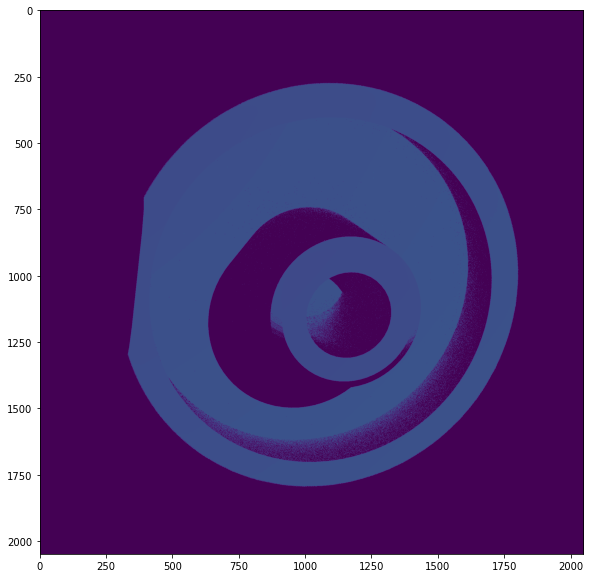

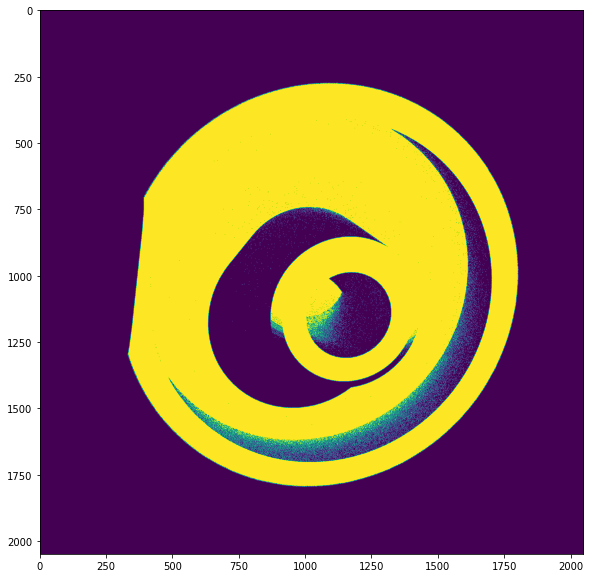

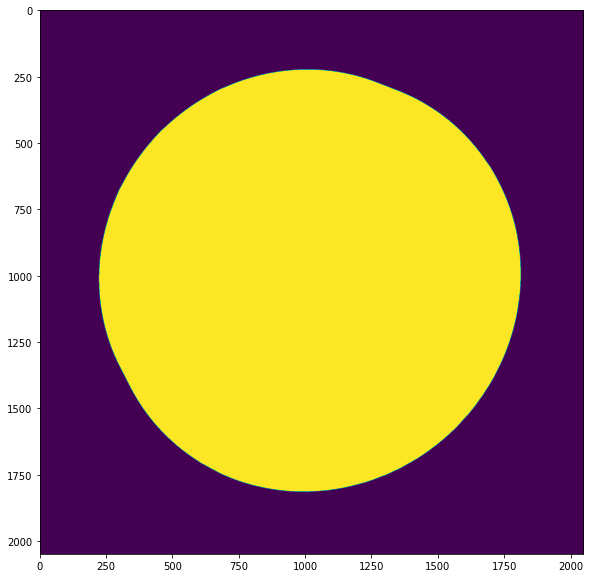

0.0014918447


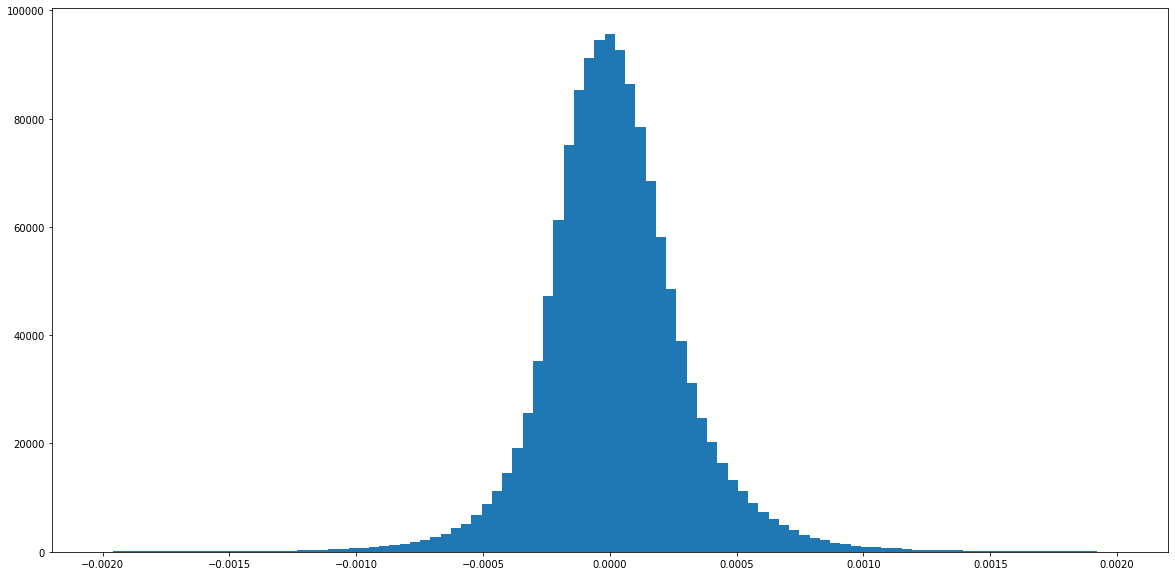

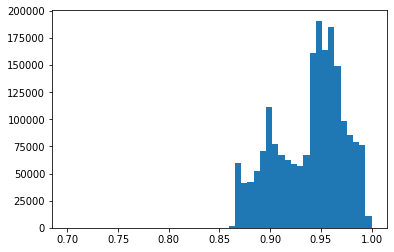

<Figure size 432x288 with 0 Axes>

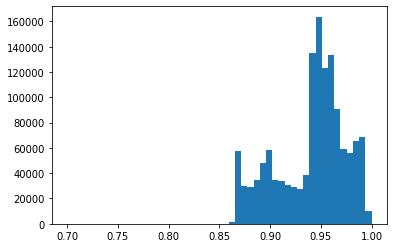

<Figure size 432x288 with 0 Axes>

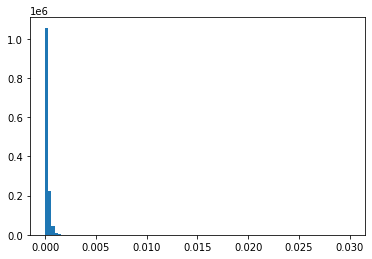

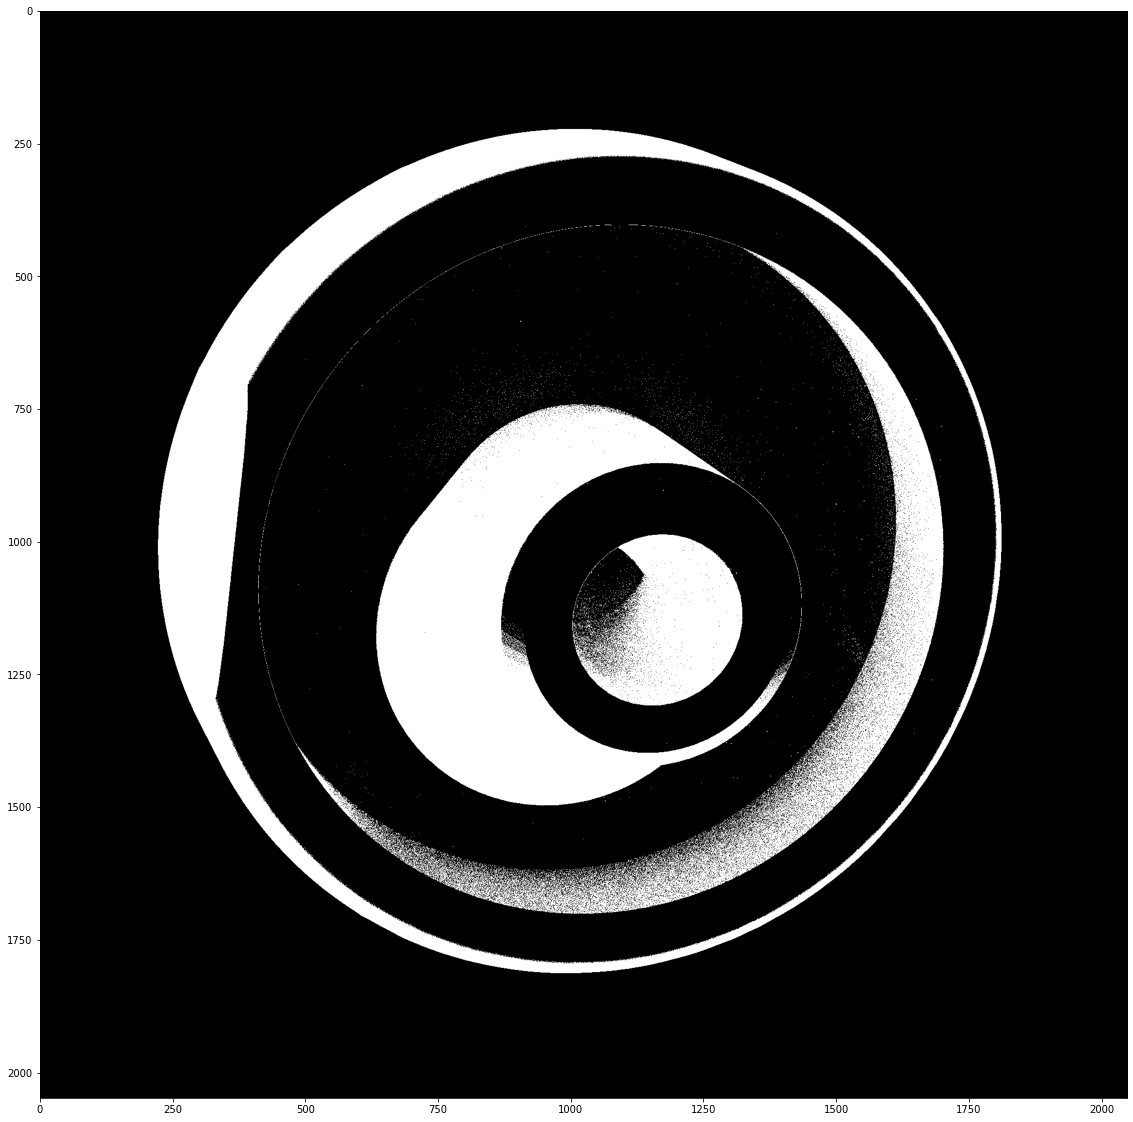

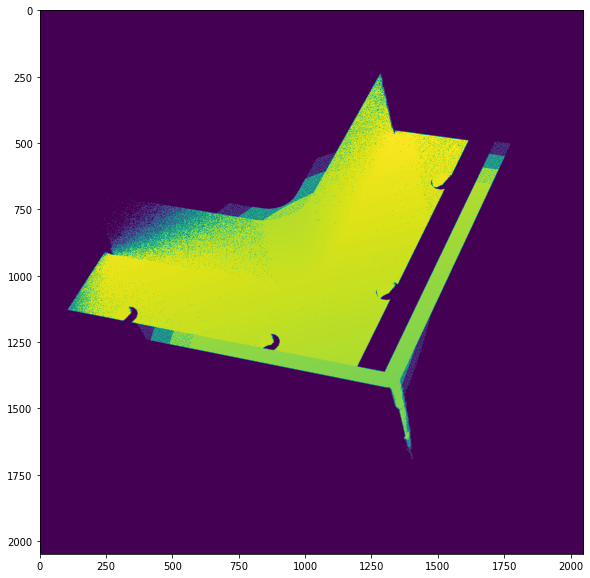

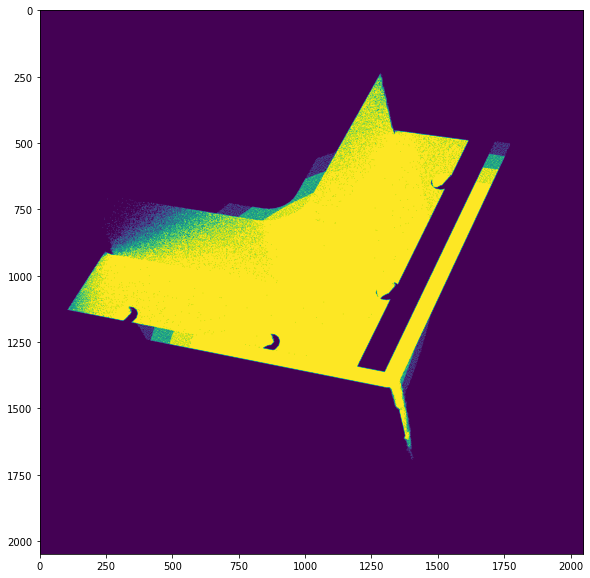

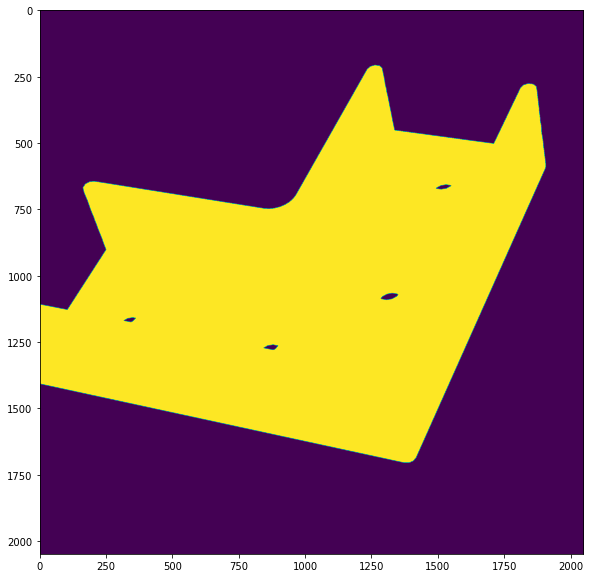

0.001526475


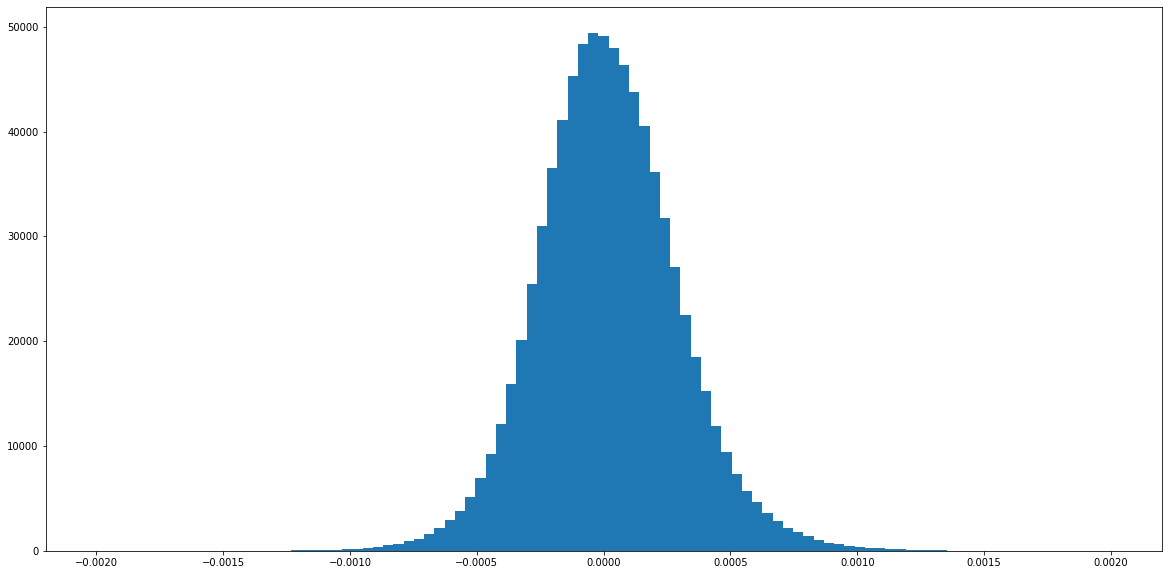

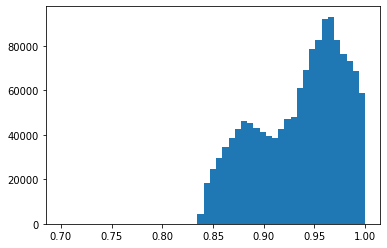

<Figure size 432x288 with 0 Axes>

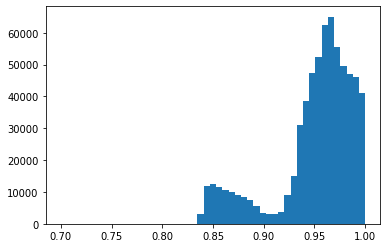

<Figure size 432x288 with 0 Axes>

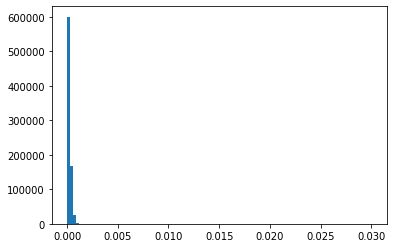

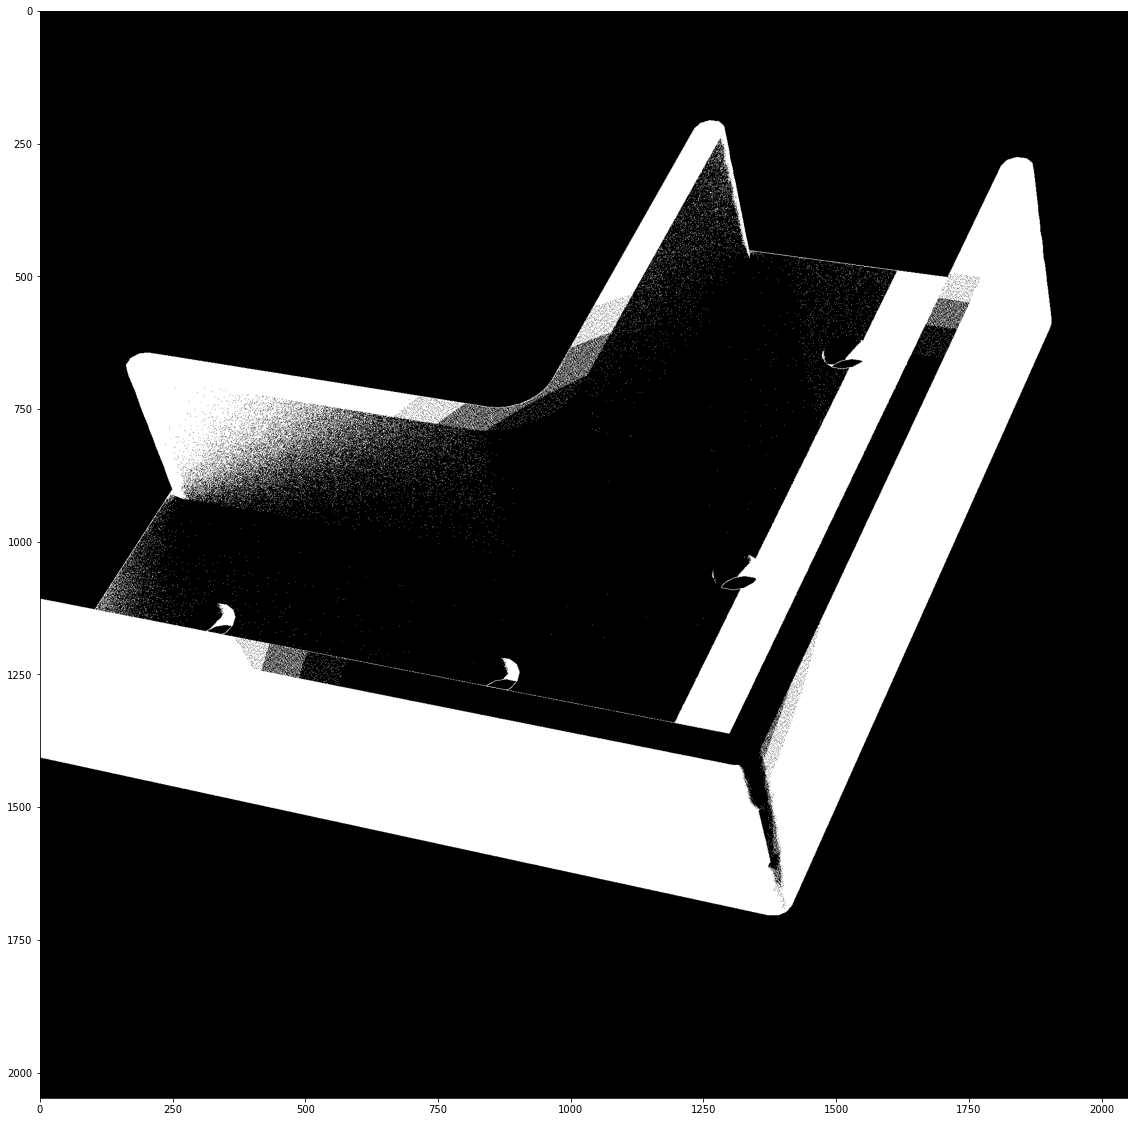

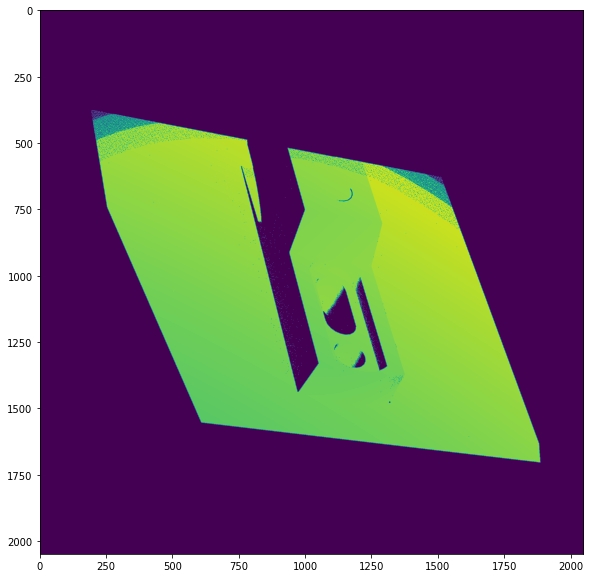

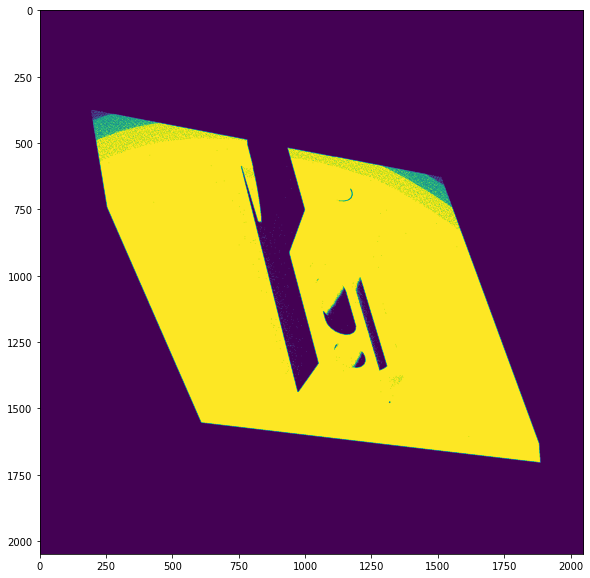

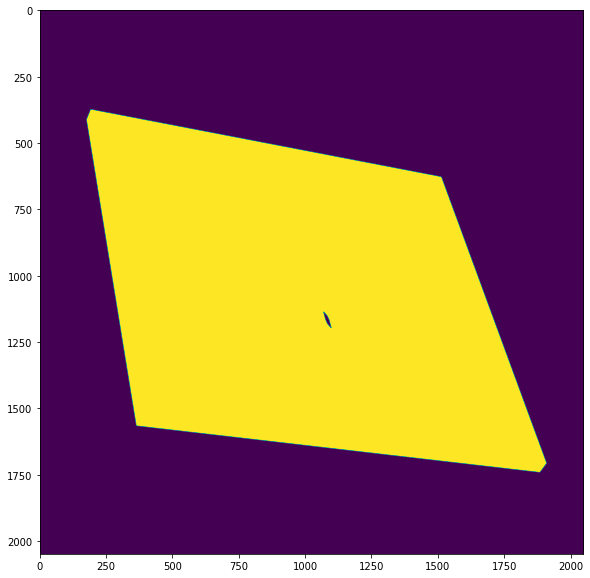

0.0014760494


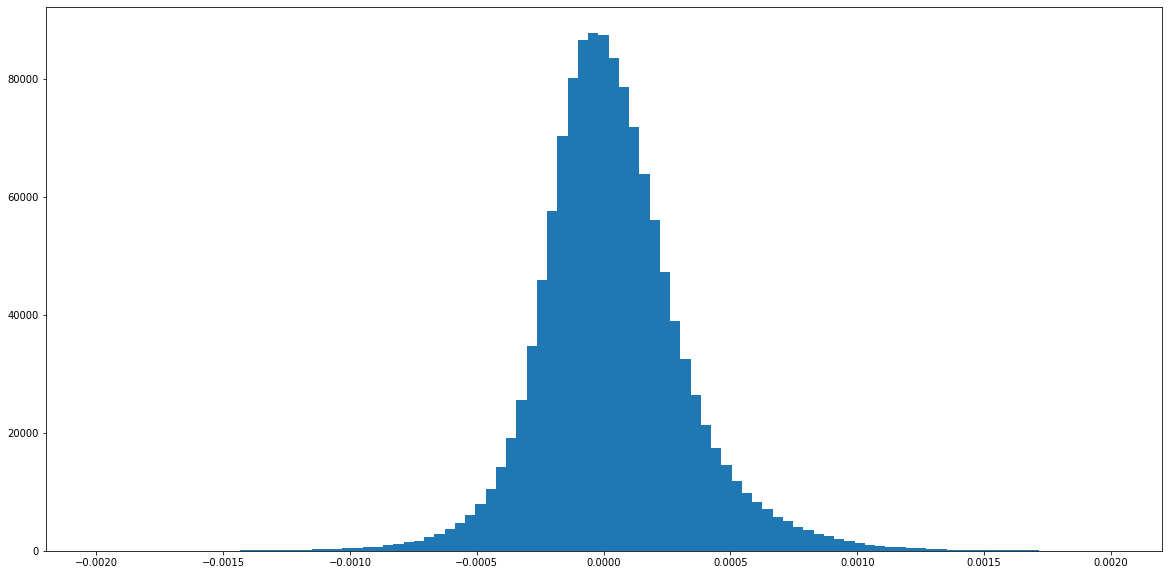

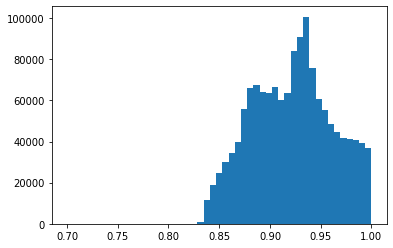

<Figure size 432x288 with 0 Axes>

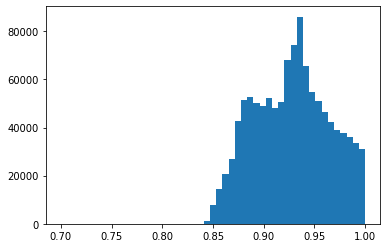

<Figure size 432x288 with 0 Axes>

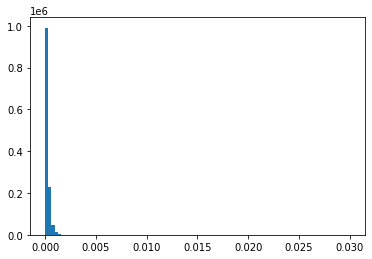

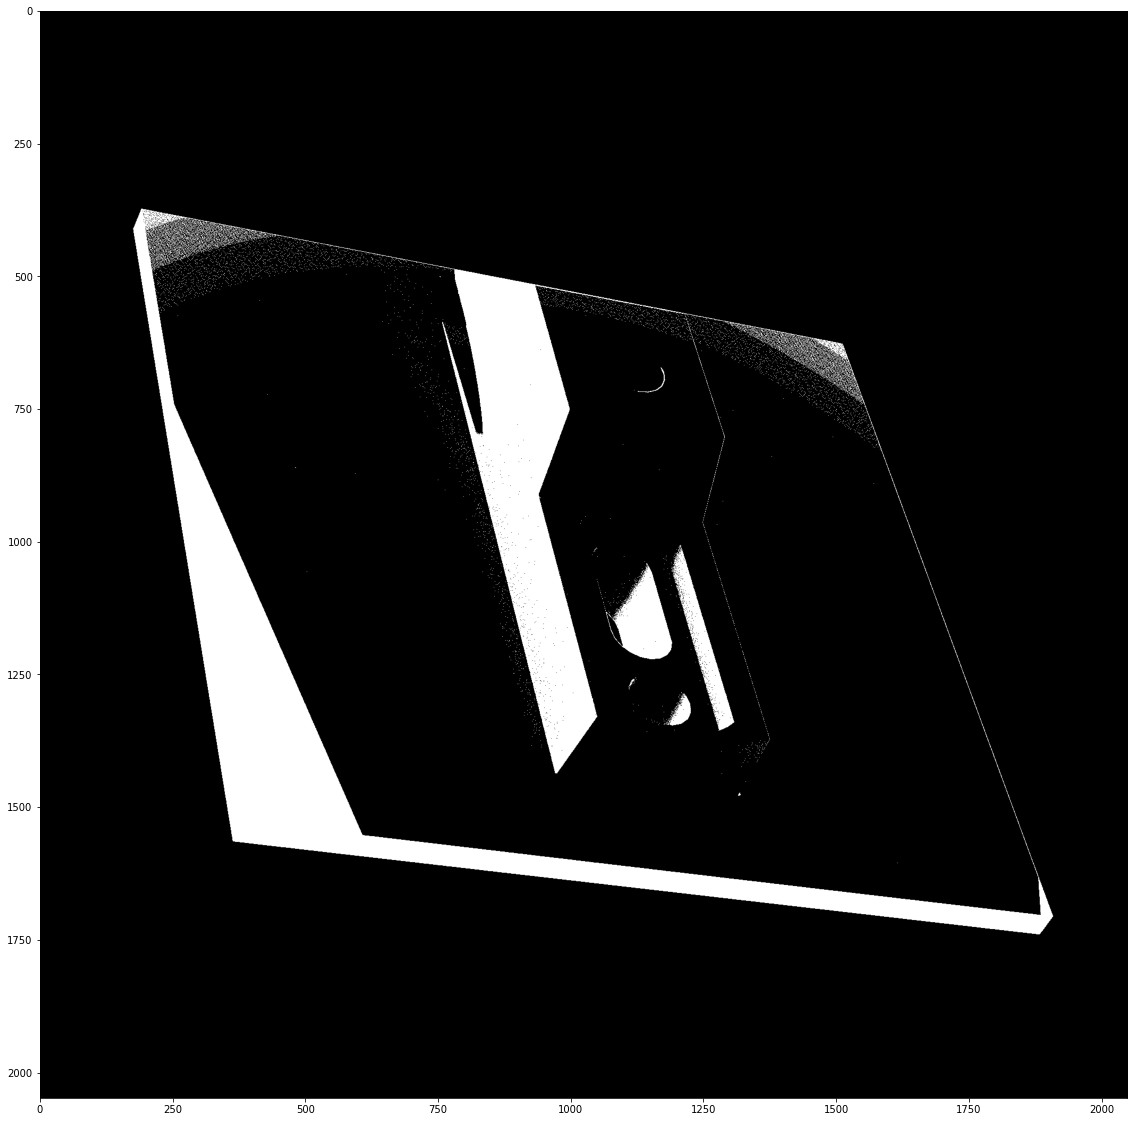

In [3]:
import OpenEXR, Imath
import numpy as np
import matplotlib.pyplot as plt
#for fide in range(0, 25):
for folder in obj_folders[:]:
    #folder = "obj_%02i"%fide
    nr = folder.split("_")[2]
    folder = folder.split("/")[2]
    #nr = folder.split("_")[1] + "_" + folder.split("_")[2]
    #print(folder, nr)
    #continue
    dmap = glob.glob("pdata/img/%s/*depth.txt"%folder)[0]
    #print(dmap)
    #continue

    with open(dmap, "r") as fi:
        lines = fi.readlines()

    width = 3232
    height = 2426
    width = 2048
    height = 2048

    dmap = np.zeros((height, width), dtype="float32")
    #print(len(lines))
    for i, l in enumerate(lines):
        el = l.strip().split("\t")
        for j, e in enumerate(el):
            dmap[i, j] = float(e) * 0.001

    med = np.median(dmap[dmap != 0.0])
#     print(med)
    #dmap[dmap > 2*med] = 0.0
    plt.figure(figsize = (10,10))
    plt.imshow(dmap)
    plt.show()
    mask = np.zeros_like(dmap)
    mask[dmap>0] = 1

    #plt.figure(figsize = (10,10))
    #plt.hist(mask.reshape(-1), np.linspace(-1, 1, 6))
    #plt.show()
    #print(np.min(dmap), np.max(dmap))

    def read_exr(exrfile):
        imagefile = OpenEXR.InputFile(exrfile)
        pt = Imath.PixelType(Imath.PixelType.FLOAT)
        header = imagefile.header()
        dw = header['dataWindow']
        channels = header['channels']
        size = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1, len(channels))

        depth = imagefile.channel("distance.Y", pt)
            # red = np.array(Image.frombytes("F", size[:2], channel))
        #print(type(depth))
        im = np.frombuffer(depth, dtype=np.float32)
#         print(im.shape, size)
        im.shape = (size[1], size[0])
        im = im.reshape(size[1], size[0])
        return im

        rgbf = [Image.fromstring("F", size, file.channel(c, pt)) for c in "RGB"]

        extrema = [im.getextrema() for im in rgbf]
        darkest = min([lo for (lo,hi) in extrema])
        lighest = max([hi for (lo,hi) in extrema])
        scale = 255 / (lighest - darkest)
        def normalize_0_255(v):
            return (v * scale) + darkest
        rgb8 = [im.point(normalize_0_255).convert("L") for im in rgbf]
        Image.merge("RGB", rgb8).save(jpgfile)

    #im = read_exr("pdata/img/2048/cam_0512x0512_00.exr")
    #im = read_exr("pdata/img/2048_2048/cam_2048x2048_00.exr")
    #im = read_exr("pdata/img/%s/cam_1920x1080_00.exr"%folder)
    im = read_exr("pdata/img/%s/cam_2048x2048_00.exr"%folder)
    #im = res
    mask2 = np.zeros_like(dmap)
    mask2[im>0] = 1

#     print(im.shape, dmap.shape, mask.shape)
    #imm = im.copy()
    #imm[mask==0] = 0.0
    plt.figure(figsize = (10,10))
    plt.imshow(mask)
    plt.show()
    plt.figure(figsize = (10,10))
    plt.imshow(mask2)
    plt.show()
#     print(np.max(dmap[mask==1]), np.min(dmap[mask==1]), np.mean(dmap[mask==1]), np.max(im[mask==1]), np.min(im[mask==1]), np.mean(im[mask==1]))
    #print(im[80:120, 40:50])
    print(np.mean(im[mask==1]) - np.mean(dmap[mask==1]))
    dmap = dmap - np.mean(dmap[mask==1])
    dmap = dmap + np.mean(im[mask==1])
    dmap[mask == 0] = 0.0
    
    
    diff = im[mask==1] - dmap[mask==1]
    plt.figure(figsize = (20,10))
    plt.hist(diff.reshape(-1), np.linspace(-0.002, 0.002, 100))
    plt.show()
    
    if True:
        plt.figure()
        plt.hist((im[im>0]).reshape(-1), np.linspace(0.7, 1.0, 50))
        plt.figure()#figsize = (20,10))
        #plt.imshow(im)
        plt.show()
        plt.hist((dmap[dmap>0]).reshape(-1), np.linspace(0.7, 1.0, 50))
        plt.figure()#figsize = (20,10))
        #plt.imshow(dmap)
        plt.show()
        diff = np.abs(im-dmap)

        plt.hist(diff[diff>0].reshape(-1), np.linspace(0, 0.03, 100))
        plt.figure(figsize = (20,20))
        difft = diff
        difft[difft > 0.01] = 1.0
        plt.imshow(difft, cmap="gray")
        plt.show()
    # diff[diff>0.5] = 0.0
    # plt.hist(diff.reshape(-1), 50)
    # plt.figure(figsize = (20,10))
    # plt.imshow(np.abs(diff), cmap="gray")
    # plt.show()
    #print(np.mean(diff), np.std(diff))
    #print(im.dtype, dmap.dtype)
    with open("pdata/img/obj_hf/%s_depth_gt.npy"%(nr), "wb") as fi:
        np.save(fi, im)
    with open("pdata/img/obj_hf/%s_depth_rec.npy"%(nr), "wb") as fi:
        np.save(fi, dmap)

In [ ]:
%matplotlib notebook
plt.figure()#figsize = (20,20))
plt.imshow(diff[500:1000, 0:500], cmap="gray")
plt.show()
vmin = min(np.min(im[500:1000, 0:500]), np.min(dmap[500:1000, 0:500]))
vmax = max(np.max(dmap[500:1000, 0:500]), np.max(im[500:1000, 0:500]))
#print(im.shape, dmap.shape)

plt.figure(figsize = (10,10))
plt.imshow(im[500:1000, 0:500],cmap="gray", vmin=vmin, vmax=vmax)
plt.show()

plt.figure()#figsize = (20,20))
plt.imshow(dmap[500:1000, 0:500], vmin=vmin, vmax=vmax, cmap="gray")
plt.show()

In [ ]:
import sympy
from sympy.combinatorics.graycode import gray_to_bin

bw = np.array(images[0:2])
vertical = np.array(images[2:24:2])
horizontal = np.array(images[24::2])
print(len(bw), len(horizontal), len(vertical))

mean_val = (bw[0] - bw[1]) * 0.5#np.mean(bw[0][bw[0] != bw[1]]) * 0.5
plt.figure(figsize = (20,10))
plt.imshow(mean_val)#, cmap="gray")
plt.show()
print(mean_val)
#mask = bw[0]>mean_val
#mask1 = np.where(bw[0]>mean_val)
if False:
    for v in vertical[:1]:
        plt.figure(figsize = (20,10))
        plt.imshow(v, cmap="gray")
        plt.show()

def get_indices(images, mean_val):
    images = images.astype(np.int32)
    G = np.stack(images.copy()) > mean_val
            
    #print(G.shape)
    lines = np.zeros_like(images[0])

    for row in range(G.shape[1]):
        for col in range(G.shape[2]):
            gg = "".join(str(x) for x in (1 * G[:, row, col]).tolist())
            gb = gray_to_bin(gg)
            #if int(gb, 2) > 230:
            #    print(gg, gb, int(gb, 2))
            lines[row, col] = int(gb, 2) 

    plt.figure(figsize = (20,10))
    plt.imshow(lines)#, cmap="gray")
    plt.show()
    return lines

#h = get_indices(horizontal, 128)
v = get_indices(vertical, mean_val)
#th = get_indices(tex_h, 128)
#tv = get_indices(tex_v, 128)
#np.min(v), np.max(v), v[200], tv[0]

In [ ]:
with open("pdata/pattern_0.txt", "r") as fi:
    lines = fi.readlines()
    
map0 = np.zeros([2048]*2, np.int32)
print(len(lines))
for i, l in enumerate(lines):
    el = l.strip().split("\t")
    for j, e in enumerate(el):
        #print(e)
        if e == 'nan':
            map0[i, j] = 0
        else:
            map0[i, j] = int(e)

%matplotlib inline           
#plt.figure(figsize = (20,10))
print(np.sum((v-map0)>=50))
viz = (v-map0)
viz[viz>=50] = 0
plt.imshow(viz)
plt.show()
print((v-map0)[280:285, 280:285], np.min(viz), np.max(viz))
print(map0.dtype, map0.shape, np.mean(viz))

In [ ]:
print(h.shape, h.dtype)

In [ ]:
import yaml
thv = np.transpose(np.stack([th, tv, np.zeros_like(tv)]), (1, 2, 0)).astype("uint32")
hv = np.transpose(np.stack([h, v, np.zeros_like(v)]), (1, 2, 0)).astype("uint32")

#hv = np.swapaxes(np.stack([h, v, np.zeros_like(v)]), 1, 2)
#print(hv.dtype, thv.dtype)
plt.figure(figsize = (20,20))
plt.imshow(hv)
plt.show()

with open("pdata/calibration.yml") as fi:
    calib = yaml.load(fi)

In [ ]:
R = np.array(calib["R"]["data"]).reshape(3,3)
T = np.array(calib["T"]["data"]).reshape(1,3)
K_c = np.array(calib["cam_K"]["data"]).reshape(3,3)
K_p = np.array(calib["proj_K"]["data"]).reshape(3,3)
kc_c = np.array(calib["cam_kc"]["data"]).reshape(1,5)
kc_p = np.array(calib["proj_kc"]["data"]).reshape(1,5)
print(kc_p.shape)

In [ ]:
#print(len(horizontal), np.max(textures_h[0]))
#print(h[600:650, 600:650])
#plt.imshow(h)
#plt.show()
import cv2

print(np.min(thv), np.max(thv), np.min(hv), np.max(hv))
points1 = []
points2 = []
for r in range(hv.shape[0]):
    for c in range(hv.shape[1]):
        if hv[r, c, 0] > 0 or hv[r, c, 1] > 0:
            points1.append((r, c))
            points2.append((hv[r,c,0], hv[r,c,1]))
            #print(hv[r, c, :2])
points1 = np.array(points1).astype("float").reshape(1, -1, 2)
points2 = np.array(points2).astype("float").reshape(1, -1, 2)
#print(points1.shape, points2.dtype)
#print(points1)

#ret, cam_mtx, cam_dist, rvecs, tvecs = cam_calib
#origin, R, proj_mtx, proj_dist = proj_calib

outp1 = cv2.undistortPoints(points1, K_c, kc_c).reshape((-1, 2))
outp2 = cv2.undistortPoints(points2, K_p, kc_p).reshape((-1, 2))

u1 = np.concatenate([outp1, np.ones((outp1.shape[0], 1))], axis=1)
u2 = np.concatenate([outp2, np.ones((outp2.shape[0], 1))], axis=1)

#print(proj_3d)
w1 = u1
#np.dot(R.T,(u2-T).T).shape)
w2 = np.dot(R.T, (u2 - T).T).T
v1 = w1
v2 = np.dot(R.T, u2.T).T
print(u2, v2)

#proj_3d = np.matmul(R, proj_3d.T).T

#print(np.multiply(cam_3d, proj_3d).shape)

#v12 = np.sum(np.multiply(cam_3d, proj_3d), axis=1).reshape(-1, 1)

#print(v12, v12.shape)
#v1 = (np.linalg.norm(cam_3d, axis=1)**2).reshape(-1, 1)
#v2 = (np.linalg.norm(proj_3d, axis=1)**2).reshape(-1, 1)
#L1 = np.matmul(cam_3d, T) * v2
#print(L1.shape)
#L = (np.matmul(cam_3d, T) * v2 + np.matmul(proj_3d, -T) * v12) / (v1 * v2 - v12**2)

#pon = cam_3d * L[:]
#pon.shape

#cv.StereoRectify(cameraMatrix1, cameraMatrix2, distCoeffs1, distCoeffs2, imageSize, R, T, R1, R2, P1, P2, Q=None, flags=CV_CALIB_ZERO_DISPARITY, alpha=-1, newImageSize=(0, 0)) -> (roi1, roi2)
#pc = cv2.triangulatePoints(p1, p2, points1.T, points2.T) #3x4, 3x4, 2xn, 2xn

In [ ]:
import meshplot as mp
mp.plot(pon)

In [ ]:
with open("pdata/depth_2048_2048_256.txt", "r") as fi:
#with open("pdata/depth05.txt", "r") as fi:

    lines = fi.readlines()
    
#with open("pdata/depth_2048.txt", "r") as fi:
#    lines = fi.readlines()
    
dmap = np.zeros([2048]*2, dtype="float32")
print(len(lines))
for i, l in enumerate(lines):
    el = l.strip().split("\t")
    for j, e in enumerate(el):
        #print(e)
        dmap[i, j] = float(e) * 0.01

med = np.median(dmap[dmap != 0.0])
print(med)
#dmap[dmap > 2*med] = 0.0
plt.imshow(dmap)
plt.show()
np.max(dmap)

In [ ]:
import meshplot as mp
ai = np.random.randint(0, 20000, size=20000)
print(ai)
pe2 = pc1[ai, :3]*pc1[ai, 3][:, None]*100
print(np.min(pe2), np.max(pe2), pe2.shape)
mp.plot(pe2, shading={"point_size": 0.01})
#print(pc1[:1000, :3]/ pc1[:1000, 3][:, None])

In [ ]:
# Calibration
import cv2

import patterns as pa
import matplotlib.pyplot as plt

def get_checkerboard(rows, cols, n=64):
    segment_black = np.zeros(shape = [n,n])
    segment_white = np.ones(shape = [n,n])*255
    chessboard = np.hstack((segment_black,segment_white))
    for i in range(int(np.floor((cols-1)/2))):
        chessboard = np.hstack((chessboard, segment_black))
        chessboard = np.hstack((chessboard, segment_white))
    temp = chessboard
    for i in range(rows-1):
        chessboard = np.concatenate((np.fliplr(chessboard),temp))
    return chessboard

board = get_checkerboard(15, 15)
board[:64*3+48, :] = 0
board[-64*3-48:, :] = 0
board[:, :64*4+48] = 0
board[:, -64*2-48:] = 0

matplotlib.image.imsave('rdata/checker.png', board, cmap="gray", vmin=0, vmax=255)
sc = render_scene_with_texture('rdata/checker.png', 2)
sc = cv2.cvtColor(sc, cv2.COLOR_BGR2GRAY)

ret, corners = cv2.findChessboardCorners(sc, (8,6), None)

#objpoints.append(objp)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
corners2 = cv2.cornerSubPix(sc, corners, (11,11), (-1,-1), criteria)
#imgpoints.append(corners2)

img = cv2.drawChessboardCorners(sc, (8,6), corners2, ret)

objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:6,0:8].T.reshape(-1,2)

c_ret, c_mtx, c_dist, c_rvecs, c_tvecs = cv2.calibrateCamera([objp], [corners2], sc.shape[::-1], None, None)
plt.figure(figsize = (10,10))
plt.imshow(img, cmap="gray")
plt.show()

In [ ]:
board = get_checkerboard(15, 15).astype("uint8")[:, :-64]
board[:64*3+48, :] = 0
board[-64*3-48:, :] = 0
board[:, :64*3+48] = 0
board[:, -64*1-48:] = 0
#sc = cv2.cvtColor(board, cv2.COLOR_BGR2GRAY)
#print(board.shape)
plt.imshow(board)
plt.show()
ret, corners = cv2.findChessboardCorners(board, (8,6), None)
print(ret)

#objpoints.append(objp)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
corners2 = cv2.cornerSubPix(board, corners, (11,11), (-1,-1), criteria)
#imgpoints.append(corners2)

img = cv2.drawChessboardCorners(board, (8,6), corners2, ret)

objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:6,0:8].T.reshape(-1,2)

p_ret, p_mtx, p_dist, p_rvecs, p_tvecs = cv2.calibrateCamera([objp], [corners2], board.shape[::-1], None, None)
plt.figure(figsize = (10,10))
plt.imshow(img, cmap="gray")
plt.show()

In [ ]:
#print(c_mtx, c_dist)
#print(p_mtx, p_dist)
zeros = np.zeros((3, 1))
#print(zeros)
p1 = np.hstack((c_mtx, zeros))
p2 = np.hstack((p_mtx, zeros))
p2[0, 3] = p2[0, 0] * 5.0
print(p1,"\n", p2)
#cv2.triangulatePoints(p1, p2)

In [ ]:
sensor=scene.getSensor()
sensor.setShutterOpen(0)
sensor.setShutterOpenTime(1)

stepSize=5
for i in range(0,360/stepSize):
    rotationCur=Transform.rotate(Vector(0,0,1),i*stepSize)
    rotationNext=Transform.rotate(Vector(0,0,1),(i+1)*stepSize)
    trafoCur=Transform.lookAt(rotationCur*Point(0,-6,4),Point(0,0,.5),rotationCur*Vector(0,1,0))
    trafoNext=Transform.lookAt(rotationNext*Point(0,-6,4),Point(0,0,.5),rotationNext*Vector(0,1,0))
    atrafo=AnimatedTransform()
    atrafo.appendTransform(0,trafoCur)
    atrafo.appendTransform(1,trafoNext)
    atrafo.sortAndSimplify()
    sensor.setWorldTransform(atrafo)
    scene.setDestinationFile('frame_%03i.png'%i)
    job=RenderJob('job_%i'%i,scene,queue)
    job.start()
    queue.waitLeft(0)
    queue.join()

In [ ]:
array=np.array(bitmap.getNativeBuffer())

In [ ]:
dir(scene)

In [ ]:
a = np.array([[9, 5, 7, 8], [8,5,8,1],[9,7,4,7], [7,6,2,6]])
print(np.linalg.svd(a))

In [ ]:
def create_checkerboard_ply(fname="cb", shape=[10, 8], size=20, color1=[64, 64, 64], color2=[255, 255, 255]):
    header = "ply\nformat ascii 1.0\nelement vertex %i\nproperty float x\nproperty float y\nproperty float z\nproperty float nx\nproperty float ny\nproperty float nz\nproperty uchar red\nproperty uchar green\nproperty uchar blue\nelement face %i\nproperty list uchar uint vertex_indices\nend_header\n"
    faces = []
    vertices = []
    x2 = shape[0] / 2 * size
    z2 = shape[1] / 2 * size
    vc = 0
    for r in range(shape[1]):
        for c in range(shape[0]):
            if r%2 == 0 and c%2 == 0 or (r+1)%2 == 0 and (c+1)%2 == 0:
                col = color1
            else:
                col = color2
            v0 = ((c * size) - x2, 0.0, (r * size) - z2)
            v1 = (((c+1) * size) - x2, 0.0, (r * size) - z2)
            v2 = ((c * size) - x2, 0.0, ((r+1) * size) - z2)
            v3 = (((c+1) * size) - x2, 0.0, ((r+1) * size) - z2)
            vertices.append("%0.6f %0.6f %0.6f 0.0 -1.0 0.0 %i %i %i"%(v0[0], v0[1], v0[2], col[0], col[1], col[2]))
            vertices.append("%0.6f %0.6f %0.6f 0.0 -1.0 0.0 %i %i %i"%(v1[0], v1[1], v1[2], col[0], col[1], col[2]))
            vertices.append("%0.6f %0.6f %0.6f 0.0 -1.0 0.0 %i %i %i"%(v2[0], v2[1], v2[2], col[0], col[1], col[2]))
            vertices.append("%0.6f %0.6f %0.6f 0.0 -1.0 0.0 %i %i %i"%(v3[0], v3[1], v3[2], col[0], col[1], col[2]))

            faces.append("4 %i %i %i %i"%(vc, vc+1, vc+3, vc+2))
            vc += 4

    with open(fname+"%i_%i.ply"%(shape[0], shape[1]), "w") as fi:
        fi.write(header%(len(vertices), len(faces)))
        for v in vertices:
            fi.write(v+"\n")
        for f in faces:
            fi.write(f+"\n")
    print("Created checkerboard")
    
create_checkerboard_ply()

In [ ]:

board = get_checkerboard(11, 20)
print(board.shape, np.min(board), np.max(board))
#board = 255 - board
board[32:64, :] = 255
board[-64:-32, :] = 255
board[:, 32:64] = 255
board[:, -64:-32] = 255
board[:32, :] = 0
board[-32:, :] = 0
board[:, :32] = 0
board[:, -32:] = 0

In [ ]:
import igl